# Teams Advanced Modeling

In [11]:
# import libraries 
import pandas as pd
import numpy as np
import math
from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline

# this will allow us to visualize the pipeline (may not be available in learn-env)
from sklearn import set_config
set_config(display= 'diagram')

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, \
RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
AdaBoostClassifier, GradientBoostingClassifier

from pickle import dump, load

# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)

np.random_state = 42

In [14]:
# load batting_basic
team_adv_merged = pd.read_csv('Data/team_adv_merged', index_col = 0)

# remove extra features that wont be modelled
team_adv_merged = team_adv_merged.drop(columns = ['Team', 'Year', 'Losses', 'Dollars_p'])

# remove attendance = 0 rows
team_adv_merged = team_adv_merged[team_adv_merged['Attendance'] > 0]

team_adv_merged

,Attendance,Wins,ERA_p,G_p,GS_p,CG_p,ShO_p,SV_p,BS_p,IP_p,TBF_p,H_p,R_p,ER_p,HR_p,BB_p,IBB_p,HBP_p,WP_p,BK_p,SO_p,GB_p,FB_p,LD_p,IFFB_p,Balls_p,Strikes_p,Pitches_p,RS_p,IFH_p,BU_p,BUH_p,K/9_p,BB/9_p,K/BB_p,H/9_p,HR/9_p,AVG_p,WHIP_p,BABIP_p,LOB%_p,FIP_p,GB/FB_p,LD%_p,GB%_p,FB%_p,IFFB%_p,HR/FB_p,IFH%_p,BUH%_p,Starting_p,Start-IP_p,Relieving_p,Relief-IP_p,RAR_p,WAR_p,tERA_p,xFIP_p,WPA_p,-WPA_p,+WPA_p,RE24_p,REW_p,pLI_p,inLI_p,gmLI_p,exLI_p,Pulls_p,WPA/LI_p,Clutch_p,FB% 2_p,FBv_p,SL%_p,SLv_p,CT%_p,CTv_p,CB%_p,CBv_p,CH%_p,CHv_p,SF%_p,SFv_p,KN%_p,KNv_p,XX%_p,PO%_p,wFB_p,wSL_p,wCT_p,wCB_p,wCH_p,wSF_p,wKN_p,wFB/C_p,wSL/C_p,wCT/C_p,wCB/C_p,wCH/C_p,wSF/C_p,wKN/C_p,O-Swing%_p,Z-Swing%_p,Swing%_p,O-Contact%_p,Z-Contact%_p,Contact%_p,Zone%_p,F-Strike%_p,SwStr%_p,HLD_p,SD_p,MD_p,ERA-_p,FIP-_p,xFIP-_p,K%_p,BB%_p,SIERA_p,RS/9_p,E-F_p,FA% (sc)_p,FT% (sc)_p,FC% (sc)_p,FS% (sc)_p,FO% (sc)_p,SI% (sc)_p,SL% (sc)_p,CU% (sc)_p,KC% (sc)_p,EP% (sc)_p,CH% (sc)_p,SC% (sc)_p,KN% (sc)_p,UN% (sc)_p,vFA (sc)_p,vFT (sc)_p,vFC (sc)_p,vFS (sc)_p,vFO (sc)_p,vSI (sc)_p,vSL (sc)_p,vCU (sc)_p,vKC (sc)_p,vEP (sc)_p,vCH (sc)_p,vSC (sc)_p,vKN (sc)_p,FA-X (sc)_p,FT-X (sc)_p,FC-X (sc)_p,FS-X (sc)_p,FO-X (sc)_p,SI-X (sc)_p,SL-X (sc)_p,CU-X (sc)_p,KC-X (sc)_p,EP-X (sc)_p,CH-X (sc)_p,SC-X (sc)_p,KN-X (sc)_p,FA-Z (sc)_p,FT-Z (sc)_p,FC-Z (sc)_p,FS-Z (sc)_p,FO-Z (sc)_p,SI-Z (sc)_p,SL-Z (sc)_p,CU-Z (sc)_p,KC-Z (sc)_p,EP-Z (sc)_p,CH-Z (sc)_p,SC-Z (sc)_p,KN-Z (sc)_p,wFA (sc)_p,wFT (sc)_p,wFC (sc)_p,wFS (sc)_p,wFO (sc)_p,wSI (sc)_p,wSL (sc)_p,wCU (sc)_p,wKC (sc)_p,wEP (sc)_p,wCH (sc)_p,wSC (sc)_p,wKN (sc)_p,wFA/C (sc)_p,wFT/C (sc)_p,wFC/C (sc)_p,wFS/C (sc)_p,wFO/C (sc)_p,wSI/C (sc)_p,wSL/C (sc)_p,wCU/C (sc)_p,wKC/C (sc)_p,wEP/C (sc)_p,wCH/C (sc)_p,wSC/C (sc)_p,wKN/C (sc)_p,O-Swing% (sc)_p,Z-Swing% (sc)_p,Swing% (sc)_p,O-Contact% (sc)_p,Z-Contact% (sc)_p,Contact% (sc)_p,Zone% (sc)_p,Pace_p,RA9-WAR_p,BIP-Wins_p,LOB-Wins_p,FDP-Wins_p,K-BB%_p,Pull%_p,Cent%_p,Oppo%_p,Soft%_p,Med%_p,Hard%_p,kwERA_p,TTO%_p,CH% (pi)_p,CS% (pi)_p,CU% (pi)_p,FA% (pi)_p,FC% (pi)_p,FS% (pi)_p,KN% (pi)_p,SB% (pi)_p,SI% (pi)_p,SL% (pi)_p,XX% (pi)_p,vCH (pi)_p,vCS (pi)_p,vCU (pi)_p,vFA (pi)_p,vFC (pi)_p,vFS (pi)_p,vKN (pi)_p,vSB (pi)_p,vSI (pi)_p,vSL (pi)_p,vXX (pi)_p,CH-X (pi)_p,CS-X (pi)_p,CU-X (pi)_p,FA-X (pi)_p,FC-X (pi)_p,FS-X (pi)_p,KN-X (pi)_p,SB-X (pi)_p,SI-X (pi)_p,SL-X (pi)_p,XX-X (pi)_p,CH-Z (pi)_p,CS-Z (pi)_p,CU-Z (pi)_p,FA-Z (pi)_p,FC-Z (pi)_p,FS-Z (pi)_p,KN-Z (pi)_p,SB-Z (pi)_p,SI-Z (pi)_p,SL-Z (pi)_p,XX-Z (pi)_p,wCH (pi)_p,wCS (pi)_p,wCU (pi)_p,wFA (pi)_p,wFC (pi)_p,wFS (pi)_p,wKN (pi)_p,wSB (pi)_p,wSI (pi)_p,wSL (pi)_p,wXX (pi)_p,wCH/C (pi)_p,wCS/C (pi)_p,wCU/C (pi)_p,wFA/C (pi)_p,wFC/C (pi)_p,wFS/C (pi)_p,wKN/C (pi)_p,wSB/C (pi)_p,wSI/C (pi)_p,wSL/C (pi)_p,wXX/C (pi)_p,O-Swing% (pi)_p,Z-Swing% (pi)_p,Swing% (pi)_p,O-Contact% (pi)_p,Z-Contact% (pi)_p,Contact% (pi)_p,Zone% (pi)_p,Pace (pi)_p,FRM_p,K/9+_p,BB/9+_p,K/BB+_p,H/9+_p,HR/9+_p,AVG+_p,WHIP+_p,BABIP+_p,LOB%+_p,K%+_p,BB%+_p,LD%+_p,GB%+_p,FB%+_p,HR/FB%+_p,Pull%+_p,Cent%+_p,Oppo%+_p,Soft%+_p,Med%+_p,Hard%+_p,EV_p,LA_p,Barrels_p,Barrel%_p,maxEV_p,HardHit_p,HardHit%_p,Events_p,CStr%_p,CSW%_p,Age_b,AB_b,PA_b,H_b,1B_b,2B_b,3B_b,HR_b,R_b,RBI_b,BB_b,IBB_b,SO_b,HBP_b,SF_b,SH_b,GDP_b,SB_b,CS_b,AVG_b,GB_b,FB_b,LD_b,IFFB_b,Pitches_b,Balls_b,Strikes_b,IFH_b,BU_b,BUH_b,BB%_b,K%_b,BB/K_b,OBP_b,SLG_b,OPS_b,ISO_b,BABIP_b,GB/FB_b,LD%_b,GB%_b,FB%_b,IFFB%_b,HR/FB_b,IFH%_b,BUH%_b,wOBA_b,wRAA_b,wRC_b,Bat_b,Fld_b,Rep_b,Pos_b,RAR_b,WAR_b,Spd_b,wRC+_b,WPA_b,-WPA_b,+WPA_b,RE24_b,REW_b,pLI_b,phLI_b,PH_b,WPA/LI_b,Clutch_b,FB% (Pitch)_b,FBv_b,SL%_b,SLv_b,CT%_b,CTv_b,CB%_b,CBv_b,CH%_b,CHv_b,SF%_b,SFv_b,KN%_b,KNv_b,XX%_b,PO%_b,wFB_b,wSL_b,wCT_b,wCB_b,wCH_b,wSF_b,wKN_b,wFB/C_b,wSL/C_b,wCT/C_b,wCB/C_b,wCH/C_b,wSF/C_b,wKN/C_b,O-Swing%_b,Z-Swing%_b,Swing%_b,O-Contact%_b,Z-Contact%_b,Contact%_b,Zone%_b,F-Strike%_b,SwStr%_b,BsR_b,FA% (sc)_b,FT% (sc)_b,FC% (sc)_b,FS% (sc)_b,FO% (sc)_b,SI% (sc)_b,SL% (sc)_b,CU% (sc)_b,KC% (sc)_b,EP% (sc)_b,CH% (sc)_b,SC% (sc)_b,KN% (sc)_b,UN% (s

## Feature Selection

**Feature Selection Using `feature_selection`**

In [15]:
team_adv_merged.columns

Index(['Attendance', 'Wins', 'ERA_p', 'G_p', 'GS_p', 'CG_p', 'ShO_p', 'SV_p',
       'BS_p', 'IP_p',
       ...
       'Hard%+_b', 'EV_b', 'LA_b', 'Barrels_b', 'Barrel%_b', 'maxEV_b',
       'HardHit_b', 'HardHit%_b', 'Events_b', 'CStr%_b'],
      dtype='object', length=634)

In [16]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, mutual_info_regression

In [17]:
feature_selector = SelectKBest(mutual_info_regression, k = 40)

In [18]:
df = team_adv_merged[list(team_adv_merged.columns)]

In [20]:
feature_selector.fit(df, team_adv_merged['Wins'])

# get top features
top_features = df.columns[feature_selector.get_support()]
top_features = top_features.drop(['Wins'])
top_features

Index(['ERA_p', 'SV_p', 'H_p', 'R_p', 'ER_p', 'H/9_p', 'AVG_p', 'WHIP_p',
       'LOB%_p', 'Starting_p', 'RAR_p', 'WAR_p', 'WPA_p', '-WPA_p', 'RE24_p',
       'REW_p', 'WPA/LI_p', 'wFB_p', 'wFB/C_p', 'ERA-_p', 'FIP-_p', 'xFIP-_p',
       'wFA (sc)_p', 'RA9-WAR_p', 'K/BB+_p', 'H/9+_p', 'AVG+_p', 'WHIP+_p',
       'LOB%+_p', 'K%+_p', 'Bat_b', 'RAR_b', 'WAR_b', 'wRC+_b', 'WPA_b',
       'RE24_b', 'REW_b', 'WPA/LI_b', 'Off_b'],
      dtype='object')

## Train-Test Split

Define the X as features we want to keep for the Train-Test Split

In [21]:
team_adv_merged.columns

Index(['Attendance', 'Wins', 'ERA_p', 'G_p', 'GS_p', 'CG_p', 'ShO_p', 'SV_p',
       'BS_p', 'IP_p',
       ...
       'Hard%+_b', 'EV_b', 'LA_b', 'Barrels_b', 'Barrel%_b', 'maxEV_b',
       'HardHit_b', 'HardHit%_b', 'Events_b', 'CStr%_b'],
      dtype='object', length=634)

In [25]:
# feature selection, target variable = 'W'
X = team_adv_merged[list(top_features)]

y = team_adv_merged['Wins']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

In [26]:
X_train.head(3)

,ERA_p,SV_p,H_p,R_p,ER_p,H/9_p,AVG_p,WHIP_p,LOB%_p,Starting_p,RAR_p,WAR_p,WPA_p,-WPA_p,RE24_p,REW_p,WPA/LI_p,wFB_p,wFB/C_p,ERA-_p,FIP-_p,xFIP-_p,wFA (sc)_p,RA9-WAR_p,K/BB+_p,H/9+_p,AVG+_p,WHIP+_p,LOB%+_p,K%+_p,Bat_b,RAR_b,WAR_b,wRC+_b,WPA_b,RE24_b,REW_b,WPA/LI_b,Off_b
29,3.03,45.0,1351.0,555.0,495.0,8.27,0.241,1.16,0.749,163.1,213.7,24.3,10.34,-94.36,95.55,10.56,10.93,52.3,0.36,82.0,87.0,93.0,50.6,25.3,135.0,97.0,98.0,91.0,102.0,104.0,-6.8,238.6,26.2,99.0,4.66,43.18,4.94,4.03,8.4
19,3.22,31.0,1269.0,572.0,524.0,7.80,0.230,1.14,0.759,118.0,155.4,17.4,3.11,-99.21,73.40,7.94,4.92,44.5,0.35,88.0,99.0,95.0,42.2,25.3,114.0,90.0,93.0,89.0,104.0,103.0,16.2,193.5,21.2,102.0,3.89,87.58,9.85,5.10,27.2
135,3.73,49.0,1259.0,659.0,606.0,7.76,0.229,1.24,0.744,79.5,137.1,14.5,7.12,-103.84,56.20,5.63,8.52,16.8,0.12,92.0,99.0,99.0,39.2,19.0,99.0,93.0,95.0,96.0,102.0,104.0,-0.5,278.1,28.6,100.0,7.38,46.21,4.86,6.08,7.7


In [27]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(157, 39)
(53, 39)
(157,)
(53,)


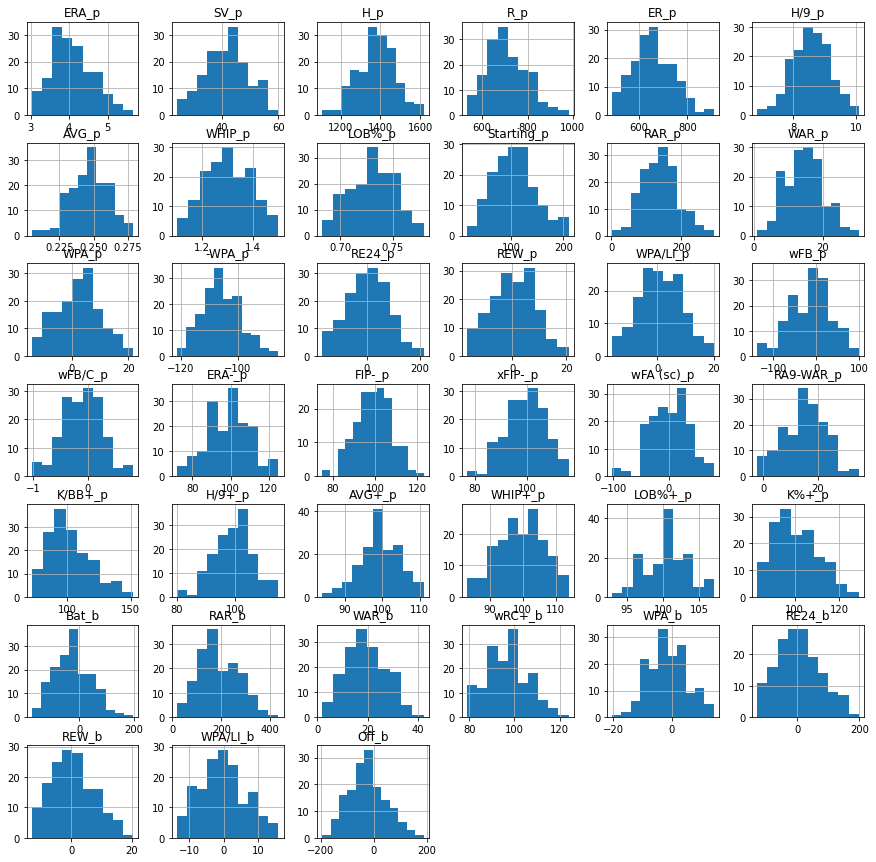

In [28]:
# check distribution of features
X_train.hist(figsize = [15,15], bins = 'auto')
plt.show()

## Preprocessing Pipeline 

In [29]:
# define numeric columns to be standard scaled
num_cols = X_train.select_dtypes(['int', 'float']).columns

In [30]:
# define numeric transformation pipeline that scales the numbers
numeric_pipeline = Pipeline([('numnorm', StandardScaler()), # apply a standard scaler
                             ])

In [32]:
# transform the selected columns with numeric pipelines
adv_teams_ct = ColumnTransformer(transformers = [("numpipe", numeric_pipeline, num_cols)])

### Pickle the Transformers

In [33]:
# save the transformer
dump(adv_teams_ct, open('pkl/adv_teams_ct.pkl', 'wb'))

In [34]:
# load the transformer
adv_teams_ct = load(open('pkl/adv_teams_ct.pkl', 'rb'))

**Transform `bb_teams`**

In [35]:
# inspect the preprocessed batting basic X train aka pp_bb_X_train
pp_X_train = pd.DataFrame(adv_teams_ct.fit_transform(X_train))
pp_X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,-1.983110,0.448396,-0.258415,-1.805037,-1.951832,-0.495732,-0.408711,-1.520862,0.895940,1.384394,1.418169,1.714580,1.017320,1.690995,1.142709,1.248364,1.269089,1.406818,1.272990,-1.563241,-1.482255,-0.840102,1.420463,1.328876,1.917568,-0.343662,-0.268691,-1.225554,0.532825,0.335609,0.243136,0.632598,0.856854,0.237774,0.934884,0.559958,0.639366,0.651314,0.460434
1,-1.631576,-1.363323,-1.115627,-1.609492,-1.604234,-1.261325,-1.201795,-1.737438,1.371634,0.268739,0.310426,0.468251,0.084308,0.965218,0.860297,0.919461,0.485037,1.241722,1.245408,-1.010266,-0.047962,-0.582492,1.176307,1.328876,0.693517,-1.386989,-1.218794,-1.519313,1.215712,0.232697,0.581401,0.066208,0.234163,0.571082,0.817072,1.204176,1.338629,0.811442,0.731430
2,-0.687984,0.966030,-1.220165,-0.608761,-0.621371,-1.326482,-1.273894,-0.654557,0.658093,-0.683649,-0.037287,-0.055569,0.601788,0.272363,0.640997,0.629475,0.954685,0.655421,0.611021,-0.641616,-0.047962,-0.067274,1.089109,0.500548,-0.180805,-0.939848,-0.838753,-0.491157,0.532825,0.335609,0.335791,1.128661,1.155746,0.348877,1.351050,0.603922,0.627973,0.958102,0.450344
3,-0.521468,0.318988,-0.760198,-0.436221,-0.429592,-0.935541,-0.913401,-0.979421,0.229969,-0.780125,-0.179793,-0.254259,1.160563,1.068473,0.616007,0.595581,0.684638,0.445877,0.445529,-0.549453,0.310611,0.061531,0.176433,0.579436,-0.239093,-0.939848,-1.028774,-1.078675,0.191382,-0.899326,1.652081,1.377320,1.417276,1.682110,0.918054,1.288040,1.332933,1.308289,1.538651
4,1.495228,-1.751548,0.849688,1.634255,1.548120,0.839984,0.889062,1.619494,-0.103016,-1.789409,-2.579586,-2.494040,-1.795911,-1.593707,-1.739168,-1.730587,-2.251968,-2.369215,-2.119600,1.570286,2.820623,2.122405,-2.788310,-1.405922,-1.463143,0.699665,0.681411,1.418275,-0.150061,-0.899326,-0.915787,-1.023873,-1.048579,-0.873253,-0.013731,-0.263451,-0.314821,-0.849704,-0.956528


In [36]:
pp_X_train.shape

(157, 39)

Now lets do the same transformation for the `X_test`

In [37]:
# inspect the preprocessed batting basic X train aka pp_bb_X_test
pp_X_test = pd.DataFrame(adv_teams_ct.transform(X_test))
pp_X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,-0.095927,0.318988,0.776511,0.012382,0.025881,0.530489,0.528569,0.320036,0.325108,-0.973076,-0.810618,-0.760016,-0.025382,-0.387570,0.057176,0.060801,-0.284664,-0.921453,-0.795662,-0.088640,0.908233,0.705554,-0.410702,0.027217,-0.647110,0.401572,0.301370,0.390119,0.191382,-0.693504,-0.184842,0.188026,0.283979,-0.206637,-0.429898,-0.050888,-0.078410,0.157460,0.003489
1,0.977178,0.707213,0.191098,0.886583,0.948814,0.302440,0.095978,-0.004828,-1.434959,-0.191376,0.243924,0.070870,-0.448657,-0.698831,-0.752320,-0.653495,-0.747789,0.348513,0.335201,1.017310,-0.406535,-0.324883,-0.401982,-1.024628,0.868382,0.401572,0.111350,-0.197398,-1.515834,0.232697,-0.980498,-0.969871,-1.061033,-0.873253,-1.305072,-0.950037,-0.999842,-0.700051,-1.117973
2,-0.761991,0.189579,-0.446584,-0.930835,-0.705274,-0.577178,-0.480810,-0.979421,0.610524,0.389952,-0.092390,-0.109757,0.781164,-0.191536,0.836200,0.852928,0.965122,0.892481,0.914423,-0.733778,-0.406535,-0.324883,0.673464,0.605732,0.926670,-0.790802,-0.648733,-1.225554,0.874268,0.129786,-0.127484,0.589899,0.582870,-0.095534,-0.162144,0.090143,0.145183,-0.049061,-0.162280
3,-0.151432,-0.328055,-0.143424,-0.286687,-0.213842,-0.039634,-0.120317,-0.437981,0.325108,0.689274,0.147020,0.052808,-0.132491,-0.059848,0.279026,0.276721,0.169329,0.185534,0.169709,-0.272966,-0.167486,0.319140,0.138647,0.237586,0.576941,0.252525,0.301370,-0.344278,0.532825,-0.590593,0.518160,0.554735,0.495693,0.571082,0.768111,0.375688,0.373048,0.326567,0.679537
4,1.828261,-1.363323,1.957791,2.048350,1.955649,1.817338,1.754244,2.052646,-2.053361,-0.532751,-0.818218,-0.850330,-1.597178,-2.530483,-1.634109,-1.546050,-1.109157,-1.844295,-1.595541,1.570286,1.027757,0.705554,-1.241993,-1.695179,-0.938550,1.742992,1.631514,1.858913,-1.857277,-0.487681,-0.503987,-0.339433,-0.351166,-0.428842,-0.096353,-0.310026,-0.386029,-0.028110,-0.235795


In [38]:
pp_X_test.shape

(53, 39)

**Log Transforming Wins**

In [39]:
# basic y
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

## Modeling

In [40]:
# import my helper function to get model results
from functions import *

### Linear Regression

In [41]:
# build pipeline 
steps = [('preprocess', adv_teams_ct), 
         ('model', LinearRegression())]

lin_reg_pipeline = Pipeline(steps)

lin_reg_pipeline.fit(X_train, log_y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['ERA_p', 'SV_p', 'H_p', 'R_p', 'ER_p', 'H/9_p', 'AVG_p', 'WHIP_p',
       'LOB%_p', 'Starting_p', 'RAR_p', 'WAR_p', 'WPA_p', '-WPA_p', 'RE24_p',
       'REW_p', 'WPA/LI_p', 'wFB_p', 'wFB/C_p', 'ERA-_p', 'FIP-_p', 'xFIP-_p',
       'wFA (sc)_p', 'RA9-WAR_p', 'K/BB+_p', 'H/9+_p', 'AVG+_p', 'WHIP+_p',
       'LOB%+_p', 'K%+_p', 'Bat_b', 'RAR_b', 'WAR_b', 'wRC+_b', 'WPA_b',
       'RE24_b', 'REW_b', 'WPA/LI_b', 'Off_b'],
      dtype='object'))])),
                ('model', LinearRegression())])

In [42]:
# instantiate the model
lr_model = Pipeline(steps).steps[1][1]  # gets the class name of the model

# get model results
model_results(lr_model, pp_X_train, log_y_train, pp_X_test, log_y_test)

             LinearRegression() RESULTS
LinearRegression() Training R2:               0.9947
LinearRegression() Test R2:                   0.9821
-------------------------------------------------------
LinearRegression() Cross Validation R2:       0.9889
LinearRegression() Cross Validation RMSE:    0
-------------------------------------------------------
LinearRegression() Training RMSE:            1
LinearRegression() Test RMSE:                1


## PCA

In [43]:
from sklearn.decomposition import PCA

In [44]:
pca = PCA(n_components=30) # Check out how `n_components` works

X_train_pca = pca.fit_transform(pp_X_train)
X_test_pca = pca.transform(pp_X_test)

In [45]:
lr_pca = LinearRegression()

# get model results
model_results(lr_pca, X_train_pca, log_y_train, X_test_pca, log_y_test)

             LinearRegression() RESULTS
LinearRegression() Training R2:               0.9933
LinearRegression() Test R2:                   0.9826
-------------------------------------------------------
LinearRegression() Cross Validation R2:       0.9887
LinearRegression() Cross Validation RMSE:    0
-------------------------------------------------------
LinearRegression() Training RMSE:            1
LinearRegression() Test RMSE:                1


In [46]:
lr_pca.coef_

array([ 0.02740702,  0.01408072,  0.00258742,  0.03734558,  0.0006473 ,
       -0.01511763, -0.01961208,  0.01705753, -0.03031279,  0.03688637,
        0.00208314,  0.00109372, -0.0203834 ,  0.00950313,  0.01691197,
       -0.02830102,  0.02452103,  0.06804149, -0.03012965,  0.03959917,
       -0.0410585 ,  0.00546166, -0.01522092,  0.01382275,  0.01541439,
        0.00505988,  0.04971834, -0.00020179,  0.01965726,  0.04327268])

### KNeighbors Regression

In [47]:
from sklearn.neighbors import KNeighborsRegressor

In [48]:
# build pipeline 
steps = [('preprocess', adv_teams_ct), 
         ('model', KNeighborsRegressor())]

knr_pipeline = Pipeline(steps)

# define parameters in the grid
knr_grid = {
            'model__n_neighbors': [10],
            'model__metric': ['minkowski', 'l1', 'l2']
           }  

# get best R2 score from grid search
knr_model = GridSearchCV(estimator = knr_pipeline,
                         param_grid = knr_grid,
                         scoring = 'r2')

knr_pipeline.fit(X_train, log_y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['ERA_p', 'SV_p', 'H_p', 'R_p', 'ER_p', 'H/9_p', 'AVG_p', 'WHIP_p',
       'LOB%_p', 'Starting_p', 'RAR_p', 'WAR_p', 'WPA_p', '-WPA_p', 'RE24_p',
       'REW_p', 'WPA/LI_p', 'wFB_p', 'wFB/C_p', 'ERA-_p', 'FIP-_p', 'xFIP-_p',
       'wFA (sc)_p', 'RA9-WAR_p', 'K/BB+_p', 'H/9+_p', 'AVG+_p', 'WHIP+_p',
       'LOB%+_p', 'K%+_p', 'Bat_b', 'RAR_b', 'WAR_b', 'wRC+_b', 'WPA_b',
       'RE24_b', 'REW_b', 'WPA/LI_b', 'Off_b'],
      dtype='object'))])),
                ('model', KNeighborsRegressor())])

In [49]:
# instantiate the model
knr_model = Pipeline(steps).steps[1][1]  # gets the class name of the model

# get model results
model_results(knr_model, pp_X_train, log_y_train, pp_X_test, log_y_test)

             KNeighborsRegressor() RESULTS
KNeighborsRegressor() Training R2:               0.9261
KNeighborsRegressor() Test R2:                   0.8731
-------------------------------------------------------
KNeighborsRegressor() Cross Validation R2:       0.8514
KNeighborsRegressor() Cross Validation RMSE:    4
-------------------------------------------------------
KNeighborsRegressor() Training RMSE:            3
KNeighborsRegressor() Test RMSE:                4


### Support Vector Machine

In [50]:
from sklearn import svm
from sklearn.svm import LinearSVR

In [51]:
# build pipeline 
svm_steps = [('preprocess', adv_teams_ct),
            ('model', svm.SVR())]

svm_pipeline = Pipeline(svm_steps)

# define parameters in the grid
svm_grid = {
            'model__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
            'model__C': [10]
           }  

# get best R2 score from grid search
svm_model = GridSearchCV(estimator = svm_pipeline,
                         param_grid = svm_grid,
                         scoring = 'r2')

# fit and give me the best params
svm_model.fit(X_train, log_y_train)
svm_model.best_params_

{'model__C': 10, 'model__kernel': 'linear'}

In [52]:
# instantiate the model
svm_model = svm_pipeline.steps[1][1]  # gets the class name of the model

# get model results
model_results(svm_model, pp_X_train, log_y_train, pp_X_test, log_y_test)

             SVR() RESULTS
SVR() Training R2:               0.885
SVR() Test R2:                   0.8331
-------------------------------------------------------
SVR() Cross Validation R2:       0.7977
SVR() Cross Validation RMSE:    7
-------------------------------------------------------
SVR() Training RMSE:            5
SVR() Test RMSE:                5


**Random Forest**

In [53]:
from sklearn.ensemble import RandomForestRegressor

In [54]:
# build pipeline 
rfr_steps = [('preprocess', adv_teams_ct), 
            ('model', RandomForestRegressor(random_state = 42))]

rfr_pipeline = Pipeline(rfr_steps)

# define parameters in the grid
rfr_grid = {'model__n_estimators': [100],
            'model__max_depth': [10],
            'model__min_samples_split': [2],
            'model__min_samples_leaf': [2, 3, 4]
           }  

# get best R2 score from grid search
rfr_model = GridSearchCV(estimator = rfr_pipeline,
                           param_grid = rfr_grid,
                           scoring = 'r2')

# fit and give me the best params
rfr_model.fit(X_train, log_y_train)
rfr_model.best_params_

{'model__max_depth': 10,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

In [55]:
# instantiate the model
rfr_model = rfr_pipeline.steps[1][1]  # gets the name of the model

# get model results
model_results(rfr_model, pp_X_train, log_y_train, pp_X_test, log_y_test)

             RandomForestRegressor(random_state=42) RESULTS
RandomForestRegressor(random_state=42) Training R2:               0.9931
RandomForestRegressor(random_state=42) Test R2:                   0.9412
-------------------------------------------------------
RandomForestRegressor(random_state=42) Cross Validation R2:       0.9245
RandomForestRegressor(random_state=42) Cross Validation RMSE:    3
-------------------------------------------------------
RandomForestRegressor(random_state=42) Training RMSE:            1
RandomForestRegressor(random_state=42) Test RMSE:                3


**CatBoost**

In [56]:
from catboost import CatBoostRegressor

In [57]:
# build pipeline 
cbr_steps = [('preprocess', adv_teams_ct), 
            ('model', CatBoostRegressor(random_state = 42,
                                        allow_writing_files=False, 
                                        verbose = False))]

cbr_pipeline = Pipeline(cbr_steps)

# define parameters in the grid
cbr_grid = {
                'model__learning_rate': [0.1],
                'model__iterations': [100],
                'model__max_depth': [5],
                'model__l2_leaf_reg': [1]
               }  

# get best R2 score from grid search
cbr_model = GridSearchCV(estimator = cbr_pipeline,
                         param_grid = cbr_grid,
                         scoring = 'r2')

# fit and give me the best params
cbr_model.fit(X_train, log_y_train)
cbr_model.best_params_

{'model__iterations': 100,
 'model__l2_leaf_reg': 1,
 'model__learning_rate': 0.1,
 'model__max_depth': 5}

In [58]:
# instantiate the model
cbr_model = cbr_pipeline.steps[1][1]  # gets the class name of the model

# get model results
model_results(cbr_model, pp_X_train, log_y_train, pp_X_test, log_y_test)

             <catboost.core.CatBoostRegressor object at 0x13f0b2b90> RESULTS
<catboost.core.CatBoostRegressor object at 0x13f0b2b90> Training R2:               1.0
<catboost.core.CatBoostRegressor object at 0x13f0b2b90> Test R2:                   0.9431
-------------------------------------------------------
<catboost.core.CatBoostRegressor object at 0x13f0b2b90> Cross Validation R2:       0.9343
<catboost.core.CatBoostRegressor object at 0x13f0b2b90> Cross Validation RMSE:    3
-------------------------------------------------------
<catboost.core.CatBoostRegressor object at 0x13f0b2b90> Training RMSE:            0
<catboost.core.CatBoostRegressor object at 0x13f0b2b90> Test RMSE:                3
